## Clutering IMDB Movie Reviews
### DS 7337 - Natural Laguage Processing - Homework 7
#### George C. Sturrock
##### March 30, 2019
##### Homework 7 Objectives
Cluster the reviews that you collected in homework 5, by doing the following:
1.	In Python, select any one of the clustering methods covered in this course. Run it over the collection of reviews, and show at least two different ways of clustering the reviews, e.g., changing k in k-Means clustering or changing where you “cut” in Agnes or Diana.  

2.	Try to write a short phrase to characterize (give a natural interpretation of) what each cluster is generally centered on semantically. Is this hard to do in some cases? If so, make note of that fact. 

3.	Explain which of the two clustering results from question 1 is preferable (if one of them is), and why. 

##### Resources
http://brandonrose.org/clustering
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/

#### Import Libraries

In [122]:
import platform; print("Platform:", platform.platform())
import os
import sys; print("Python:", sys.version)
import requests; print("Requests:", requests.__version__)
from urllib import request; ("urllib:", request.__version__)
import warnings
warnings.filterwarnings('ignore')
from time import sleep

#Web Scraping
import bs4; print("BeatifulSoup:", bs4.__version__)
from bs4 import BeautifulSoup
import json; print("json:", json.__version__)

#Python Basics
import numpy as np; print("Numpy Version:", np.__version__)
import pandas as pd; print("Pandas Version:", pd.__version__)
from matplotlib import pyplot as plt
import seaborn as sns;

#NLP
import nltk; print("NLTK Version:", nltk.__version__)
#nltk.download('conll2000')
from nltk.corpus import conll2000

import spacy; print("Spacy Version:", spacy.__version__)
from spacy import displacy
#nlp = spacy.load('en')
#import en_core_web_sm; print("en_core_web_sm Version:", en_core_web_sm.__version__)
#nlp = en_core_web_sm.load()
#To Install:  python -m spacy download en_core_web_sm
import en_core_web_md; print("en_core_web_md Version:", en_core_web_md.__version__)
nlp = en_core_web_md.load()

import pattern; print("Pattern Version:", pattern.__version__)
from pattern.en import tag, parse
from pattern.en import parsetree

Platform: Windows-10-10.0.14393-SP0
Python: 3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]
Requests: 2.21.0
BeatifulSoup: 4.6.0
json: 2.0.9
Numpy Version: 1.15.4
Pandas Version: 0.23.0
NLTK Version: 3.4
Spacy Version: 2.0.16
en_core_web_md Version: 2.0.0
Pattern Version: 3.6


### Data Acquisition
The first three films in the "Rocky" series will be utilized to collect reviews for noun phrase chunking.  Link to the main user review page for each of the three movies are shown below.  To assure both positive and negative reviews are collected, there are two links per movie.  One is sorted descending by user rating.  The other is sorted ascending by user rating.  Both links have "spoiler alert" messages suppressed as these reviews are often more akin to a summarization of the movie plot instead of a true review.  

In [7]:
#Rocky movie list.  Two links for each movie to assure positive and negative reviews are captured.  
#Sort descending by Review Rating.  Sort ascending by Review Rating.

#Rocky
rockyDict = {"aRocky":"https://www.imdb.com/title/tt0075148/reviews?spoiler=hide&sort=userRating&dir=asc&ratingFilter=0", 
         "dRocky":"https://www.imdb.com/title/tt0075148/reviews?spoiler=hide&sort=userRating&dir=desc&ratingFilter=0", 
#Rocky 2
         "dRocky 2":"https://www.imdb.com/title/tt0079817/reviews?spoiler=hide&sort=userRating&dir=desc&ratingFilter=0",
         "aRocky 2":"https://www.imdb.com/title/tt0079817/reviews?spoiler=hide&sort=userRating&dir=asc&ratingFilter=0",
#Rocky 3
         "dRocky 3":"https://www.imdb.com/title/tt0084602/reviews?spoiler=hide&sort=userRating&dir=desc&ratingFilter=0",
         "aRocky 3":"https://www.imdb.com/title/tt0084602/reviews?spoiler=hide&sort=userRating&dir=asc&ratingFilter=0"
            }

rockyKeys = rockyDict.keys()

#### Web Scraping IMDB Movie Review Titles
The individual links to the user reviews are collected below.  A get request uses each of the links in the "rockyDict" python dictionary.  The response is parsed by Beautiful Soup to find the individual links to each individual review.  The review URLs along with the movie name are written to a dataframe named dfRockyReviews.

In [8]:
reviewUrls = list()
dfRockyReviews = pd.DataFrame(columns = ['Movie', 'ReviewURL'])

for r in rockyKeys:
    #print(r, rockyDict[r])
    response = requests.get(rockyDict[r])
    soup = BeautifulSoup(response.text, 'html.parser')
    rUrls = ["http:" + s.attrs['href'] for s in soup.find_all(href = True, class_ = 'title')]
    reviewUrls = reviewUrls + rUrls
    for u in rUrls:
        dfRockyReviews = dfRockyReviews.append({'Movie':r[1:], 'ReviewURL':u}, ignore_index=True)

A sample of the dfRockyReviews dataframe is shown below.

In [9]:
dfRockyReviews[0:5]

,Movie,ReviewURL
0,Rocky,http:/review/rw4247059/?ref_=tt_urv
1,Rocky,http:/review/rw0149538/?ref_=tt_urv
2,Rocky,http:/review/rw0149534/?ref_=tt_urv
3,Rocky,http:/review/rw2406266/?ref_=tt_urv
4,Rocky,http:/review/rw3451942/?ref_=tt_urv


#### Web Scraping IMDB Movie Review Details
The individual review URLs collected above will be requested and parsed to retrieve key qualitative and categorical data about each review along with the review text itself.  These details are stored in a new dataframe named dfReviewDetails.  The first five records are this dataframe are shown below.

In [10]:
dfReviewDetails = pd.DataFrame(columns=['Movie', 'ReviewUrl', 'ReviewDate', 'ReviewTitle', 'Review', 'Rating', 
                                        'Language'])
counter = 0

for r in reviewUrls:
    fullUrl = "https://www.imdb.com" + r[5:]
    response2 = requests.get(fullUrl)
    soup2 = BeautifulSoup(response2.text, 'html.parser')
    rjson = soup2.find('script', type = 'application/ld+json').text
    rjson = json.loads(rjson)
    
    try:
        rating = rjson['reviewRating']['ratingValue']
    except Exception as e:
        #print("No User Rating")
        rating = 5
    
    dfReviewDetails = dfReviewDetails.append({'Movie':dfRockyReviews.Movie[counter], 'ReviewUrl':r, 
                                              'ReviewDate':rjson['dateCreated'], 'ReviewTitle':rjson['name'], 
                                              'Review':rjson['reviewBody'], 'Rating':rating, 
                                              'Language':rjson['inLanguage']}, ignore_index=True)
    counter += 1

dfReviewDetails[0:5]

,Movie,ReviewUrl,ReviewDate,ReviewTitle,Review,Rating,Language
0,Rocky,http:/review/rw4247059/?ref_=tt_urv,2018-07-21,Rubbish,The fight scenes are pathetic and the acting i...,1,English
1,Rocky,http:/review/rw0149538/?ref_=tt_urv,1999-11-25,"Dumbest, Most Cornball Film Ever Made",I still remember my initial outrage that this ...,1,English
2,Rocky,http:/review/rw0149534/?ref_=tt_urv,1998-08-19,overrated piece of cheese,grubby late-night fare achieved way too much s...,2,English
3,Rocky,http:/review/rw2406266/?ref_=tt_urv,2011-03-30,I can't believe the script was made into a mov...,I was told by many that Rocky is a beautiful m...,3,English
4,Rocky,http:/review/rw3451942/?ref_=tt_urv,2016-04-15,Hate me if you want but I didn't like this film,I'm going to come out and say it. I didn't lik...,3,English


The bar plot below shows movie review ratings for the reviews collected in the prior step. The original "Rocky" is widely considered the best of the "Rocky" series.  It won multiple Oscars and introduced "Steady-Cam" technology to the movie world.  However, the sample of user reviews collected tell a different story.  

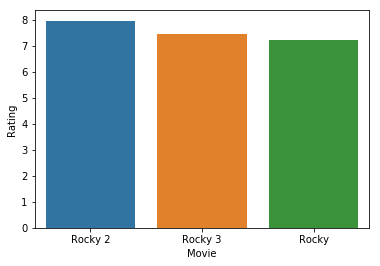

In [11]:
plotdf = dfReviewDetails.sort_values(by=['ReviewDate'])
plotdf.Rating = plotdf.Rating.astype('int64')
plotdf.ReviewDate = pd.to_datetime(plotdf.ReviewDate)
plotdf = plotdf.groupby(['Movie']).mean().reset_index()
sns.barplot(x='Movie', y='Rating', data=plotdf.sort_values(by=['Rating'], ascending=False))

### Question 7.1 - Review Clustering

In [12]:
#TFIDF Vectorizing - sklearn libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [18]:
tfidfVectorizer = TfidfVectorizer(max_df=1, min_df=0, stop_words='english', use_idf=True, ngram_range=(1,3))

tfidfMatrix = tfidfVectorizer.fit_transform(dfReviewDetails.Review)
tfidfMatrix.shape

(150, 27371)

In [125]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidfMatrix)

In [118]:
reviewFeatures = tfidfVectorizer.get_feature_names()
#reviewFeatures

##### KMeans Clustering

In [61]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=4, tol=0.0001, init = 'random')
kmFit = km.fit(tfidfMatrix)
clusters = km.labels_.tolist()

In [62]:
np.unique(clusters)

array([0, 1, 2, 3])

In [63]:
reviewDict = {'cluster': clusters, 'movie': dfReviewDetails.Movie, 'rating': dfReviewDetails.Rating, 'title': dfReviewDetails.ReviewTitle, 
              'review': dfReviewDetails.Review}

In [86]:
#dfKmClust = pd.DataFrame(reviewDict, index=clusters, columns = ['cluster', 'movie', 'rating', 'title', 'review'])

dfKmClust = pd.DataFrame.from_dict(reviewDict)
dfKmClust['rating'] = dfKmClust['rating'].astype('int64')
dfKmClust.head()

,cluster,movie,rating,title,review
0,3,Rocky,1,Rubbish,The fight scenes are pathetic and the acting i...
1,3,Rocky,1,"Dumbest, Most Cornball Film Ever Made",I still remember my initial outrage that this ...
2,0,Rocky,2,overrated piece of cheese,grubby late-night fare achieved way too much s...
3,3,Rocky,3,I can't believe the script was made into a mov...,I was told by many that Rocky is a beautiful m...
4,3,Rocky,3,Hate me if you want but I didn't like this film,I'm going to come out and say it. I didn't lik...


In [121]:
dfKmClust['cluster'].value_counts()
#sns.distplot(dfKmClust['cluster'].value_counts())

3    99
0    49
2     1
1     1
Name: cluster, dtype: int64

In [90]:
clusterRate = dfKmClust['rating'].groupby(dfKmClust['cluster'])
clusterRate.mean()

cluster
0     7.591837
1     3.000000
2    10.000000
3     7.525253
Name: rating, dtype: float64

In [117]:
clusterMovie = dfKmClust['movie'].groupby(dfKmClust['cluster'])
clusterMovie.sum()

cluster
0    RockyRockyRockyRockyRockyRockyRockyRockyRockyR...
1                                                Rocky
2                                              Rocky 3
3    RockyRockyRockyRockyRockyRockyRockyRockyRockyR...
Name: movie, dtype: object

##### Hierarchical Clustering

In [124]:
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.cluster import AgglomerativeClustering

In [132]:
ac = AgglomerativeClustering(n_clusters=4, linkage='ward')

In [136]:
denseTfidf = tfidfMatrix.toarray()

In [137]:
acFit = ac.fit(denseTfidf)

In [142]:
acFit.labels_
clusters2 = acFit.labels_.tolist()

In [149]:
dfacPlot = dfReviewDetails
dfacPlot['cluster'] = clusters2
#dfacPlot.pivot('Movie', 'cluster').plot(kind='bar')

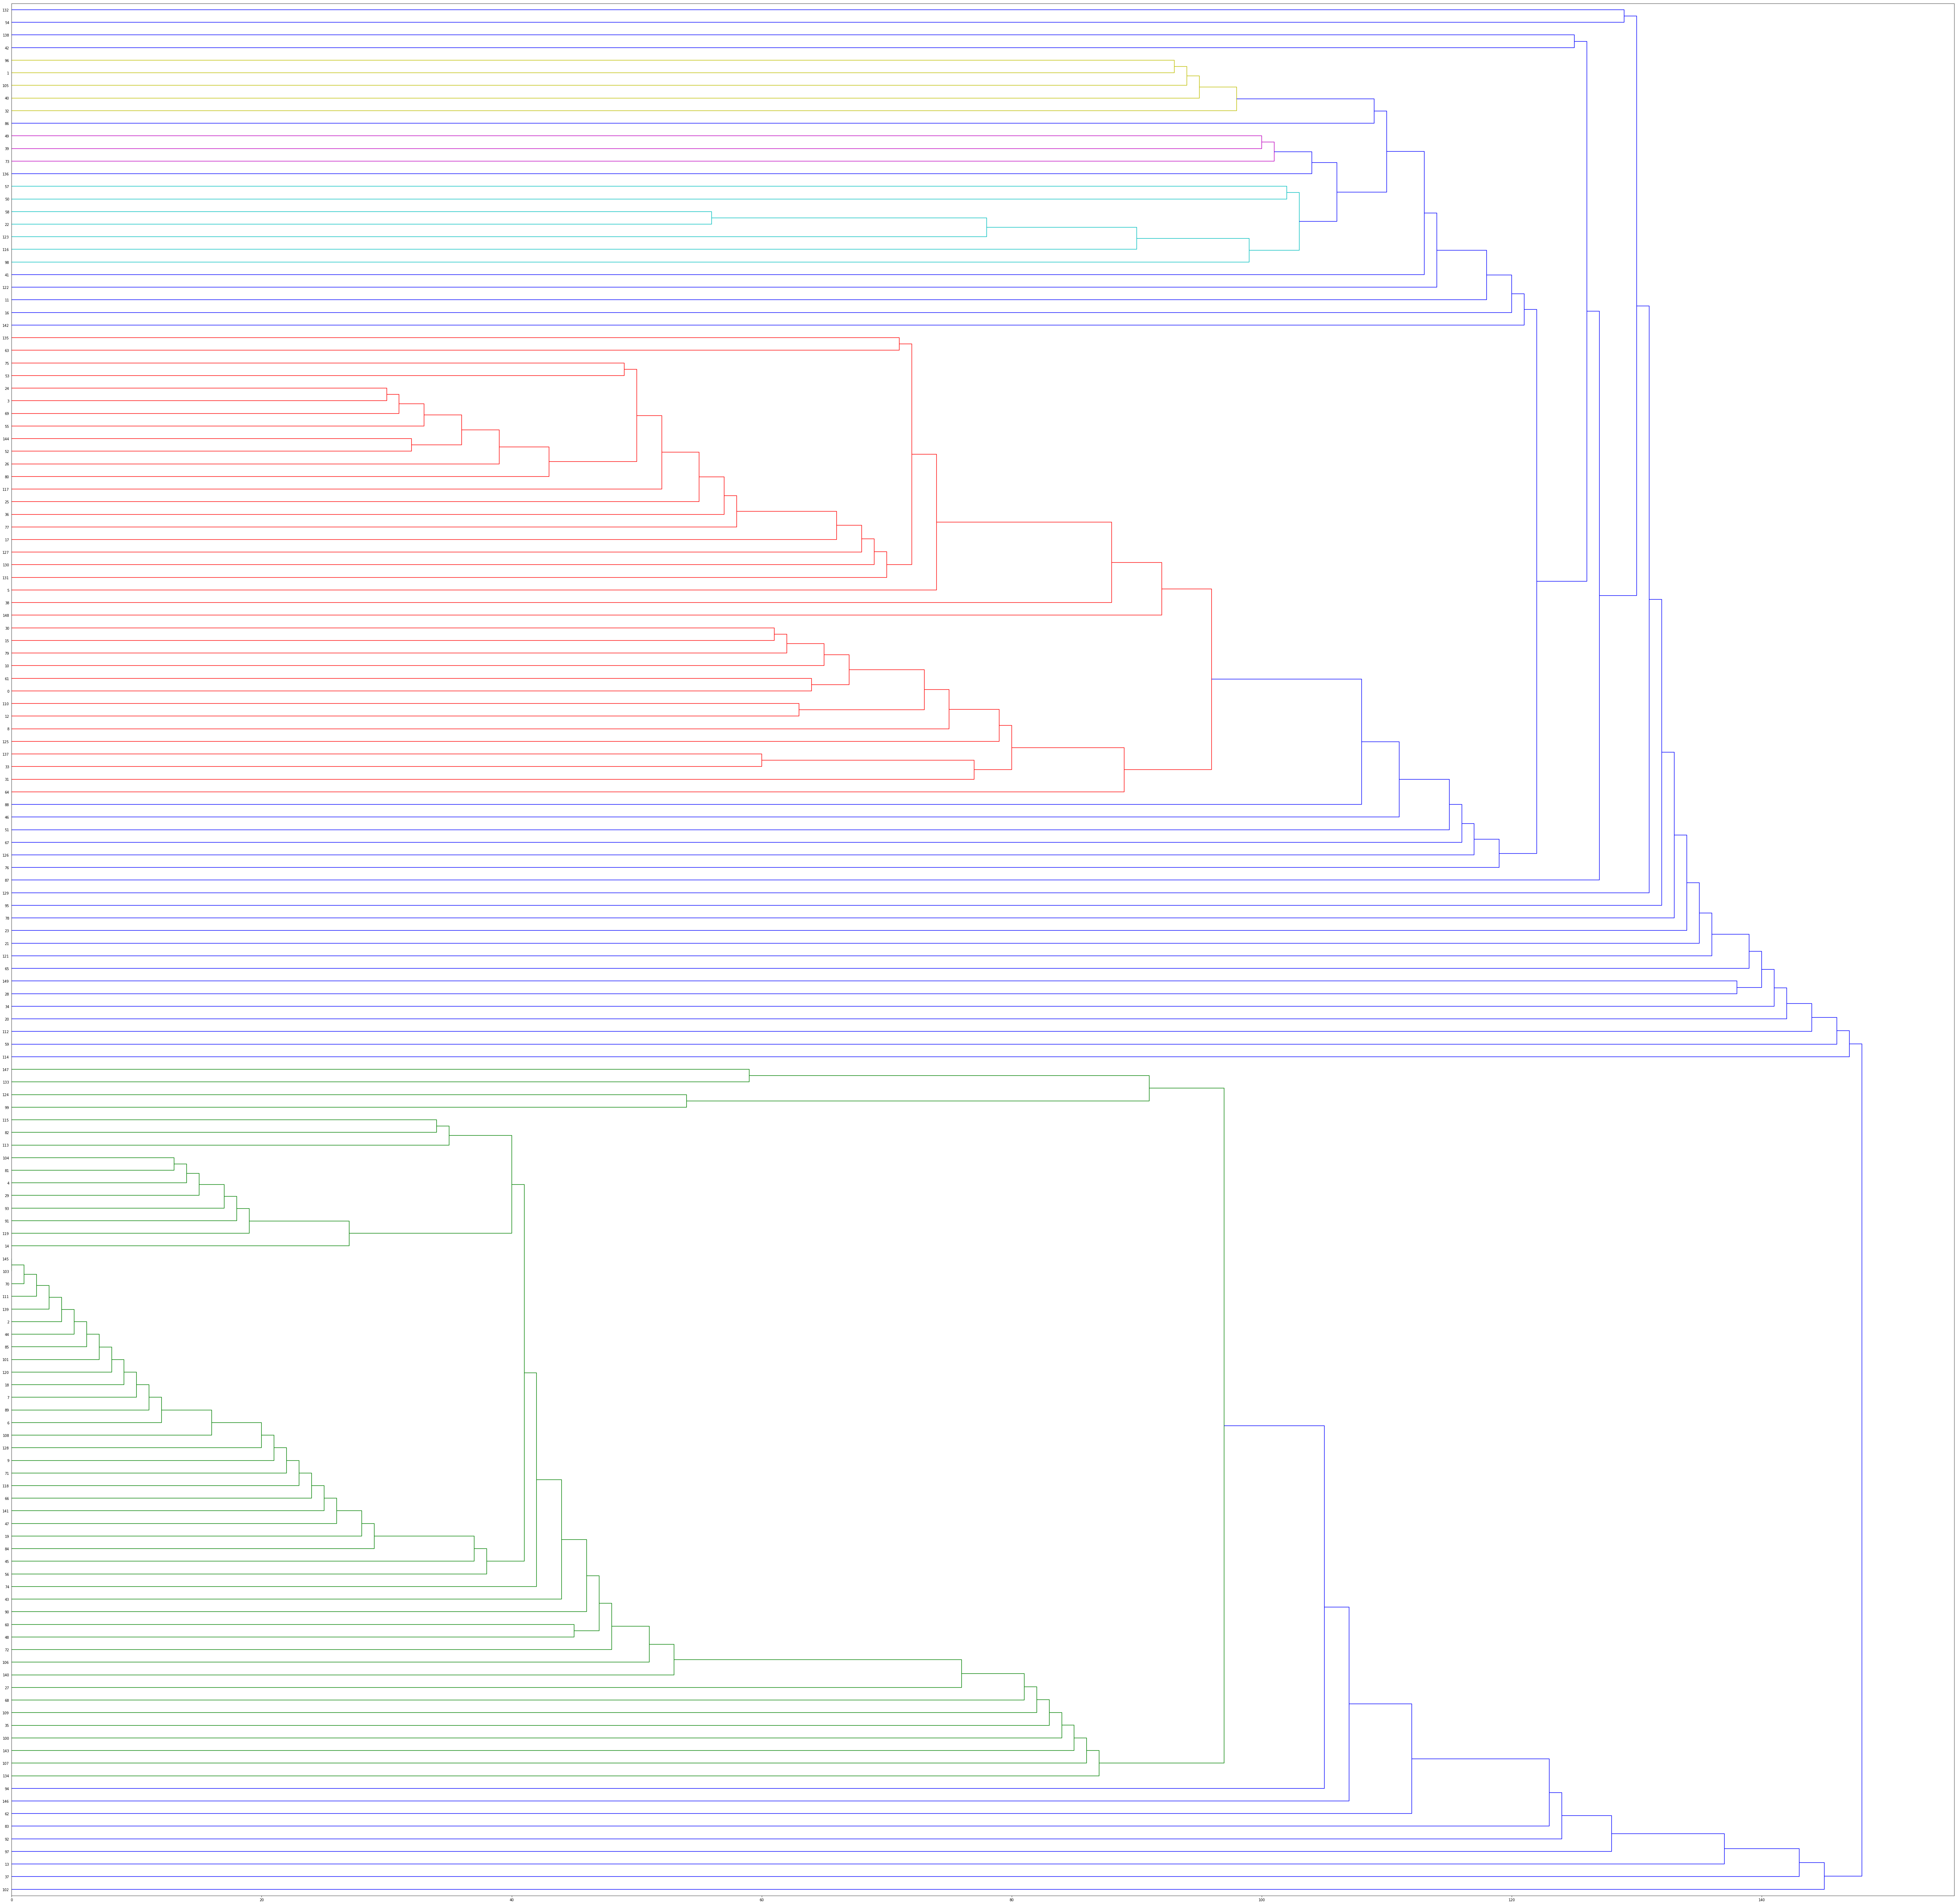

In [155]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html
plt.figure(figsize=(100,100))
children = acFit.children_
distance = np.arange(children.shape[0])
no_of_observations = np.arange(2, children.shape[0]+2)
linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

#dn = dendrogram(linkage_matrix, labels=dfReviewDetails.index, p=4, truncate_mode='level', show_leaf_counts=False, 
#                orientation='right', leaf_font_size=10)

dn = dendrogram(linkage_matrix, labels=dfReviewDetails.index, show_leaf_counts=False, 
                orientation='right', leaf_font_size=10)

plt.show()

In [147]:
dfacPlot

,Movie,ReviewUrl,ReviewDate,ReviewTitle,Review,Rating,Language,cluster
0,Rocky,http:/review/rw4247059/?ref_=tt_urv,2018-07-21,Rubbish,The fight scenes are pathetic and the acting i...,1,English,1
1,Rocky,http:/review/rw0149538/?ref_=tt_urv,1999-11-25,"Dumbest, Most Cornball Film Ever Made",I still remember my initial outrage that this ...,1,English,1
2,Rocky,http:/review/rw0149534/?ref_=tt_urv,1998-08-19,overrated piece of cheese,grubby late-night fare achieved way too much s...,2,English,0
3,Rocky,http:/review/rw2406266/?ref_=tt_urv,2011-03-30,I can't believe the script was made into a mov...,I was told by many that Rocky is a beautiful m...,3,English,1
4,Rocky,http:/review/rw3451942/?ref_=tt_urv,2016-04-15,Hate me if you want but I didn't like this film,I'm going to come out and say it. I didn't lik...,3,English,0
5,Rocky,http:/review/rw3647093/?ref_=tt_urv,2017-02-24,Eh....it was alright.,I didn't particularly like this movie. Dimwitt...,3,English,1
6,Rocky,http:/review/rw1979442/?ref_=tt_urv,2008-11-22,The most overrated movie of all time,I went to see this movie when it came out. I h...,3,English,0
7,Rocky,http:/review/rw3794060/?ref_=tt_urv,2017-08-31,A screaming movie with some boxing undertones,It's been a long time since I last watched it....,4,English,0
8,Rocky,http:/review/rw0149606/?ref_=tt_urv,2001-09-25,Good to watch,This movie is worth a viewing every now and ag...,4,English,1
9,Rocky,http:/review/rw1320822/?ref_=tt_urv,2006-03-20,an iconic film,'Rocky' is a film about a boxer who goes to ul...,4,English,0
